In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('AIML Dataset.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [4]:
df.shape

(6362620, 11)

In [5]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [6]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [7]:
df.groupby('type')['isFraud'].mean()

type
CASH_IN     0.000000
CASH_OUT    0.001840
DEBIT       0.000000
PAYMENT     0.000000
TRANSFER    0.007688
Name: isFraud, dtype: float64

In [8]:
# df['type'].groupby(df['isFraud']).value_counts()
df_fraud_value_count = df[df['isFraud']==1]['type'].value_counts()
df_fraud_value_count


type
CASH_OUT    4116
TRANSFER    4097
Name: count, dtype: int64

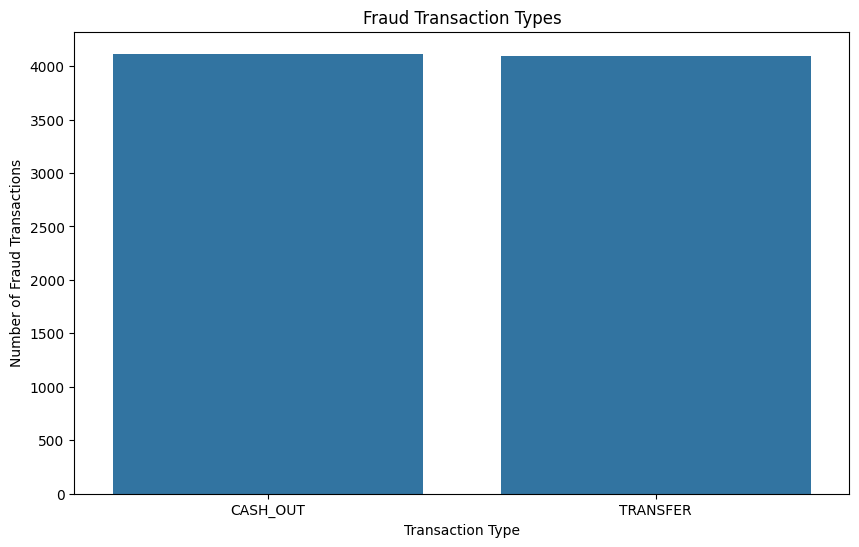

In [9]:
plt.figure(figsize=(10,6))
sns.barplot(x=df_fraud_value_count.index, y=df_fraud_value_count.values)
plt.title('Fraud Transaction Types')
plt.xlabel('Transaction Type')
plt.ylabel('Number of Fraud Transactions')
plt.show()

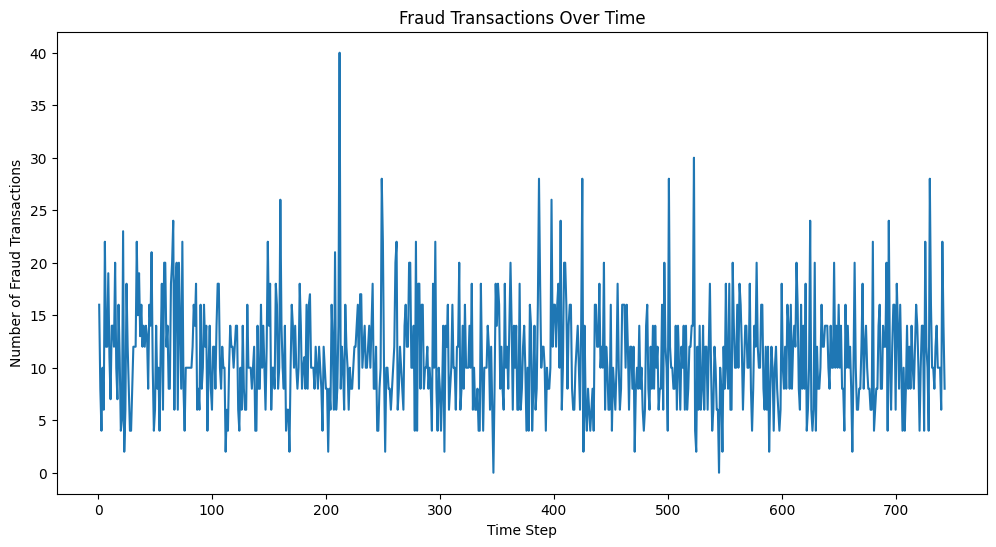

In [10]:
df_fraud_over_time = df.groupby('step')['isFraud'].sum()
# df_fraud_over_time.plot(figsize=(12,6))
# plt.title('Fraud Transactions Over Time')
# plt.xlabel('Time Step')
# plt.ylabel('Number of Fraud Transactions')
# plt.show()

plt.figure(figsize=(12,6))
sns.lineplot(x=df_fraud_over_time.index, y=df_fraud_over_time.values)
plt.title('Fraud Transactions Over Time')
plt.xlabel('Time Step')
plt.ylabel('Number of Fraud Transactions')
plt.show()

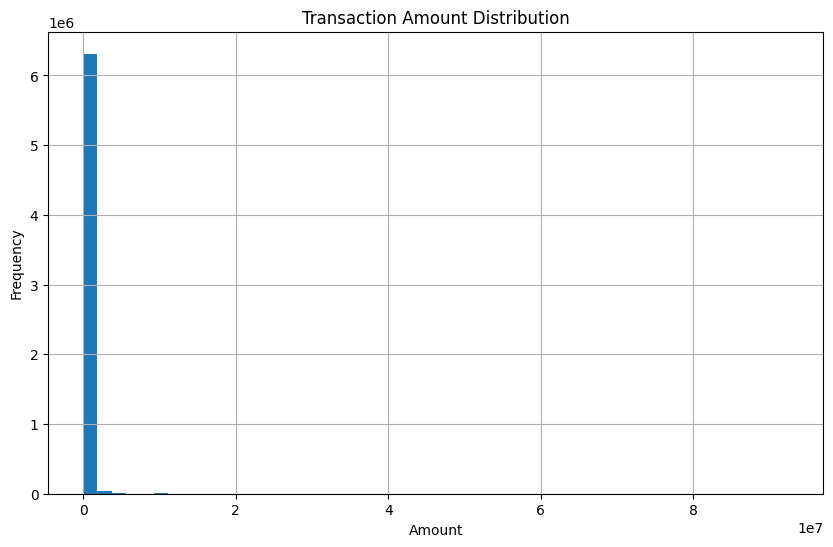

In [11]:
df['amount'].hist(bins=50, figsize=(10,6))
plt.title('Transaction Amount Distribution')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

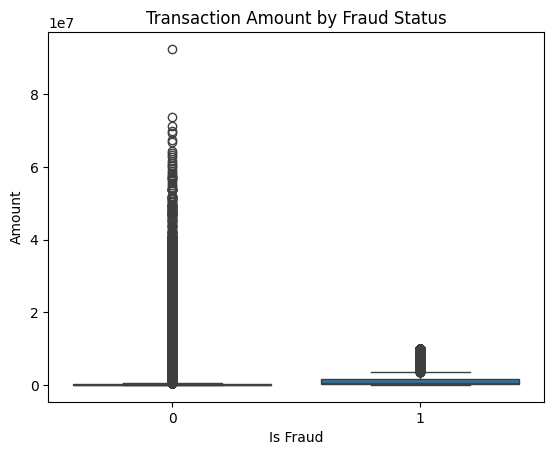

In [12]:
sns.boxplot(x='isFraud', y='amount', data=df)
plt.title('Transaction Amount by Fraud Status')
plt.xlabel('Is Fraud')
plt.ylabel('Amount')
plt.show()

/tmp/ipykernel_106446/2307414797.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rate=df.groupby('amount_bin')['isFraud'].mean()


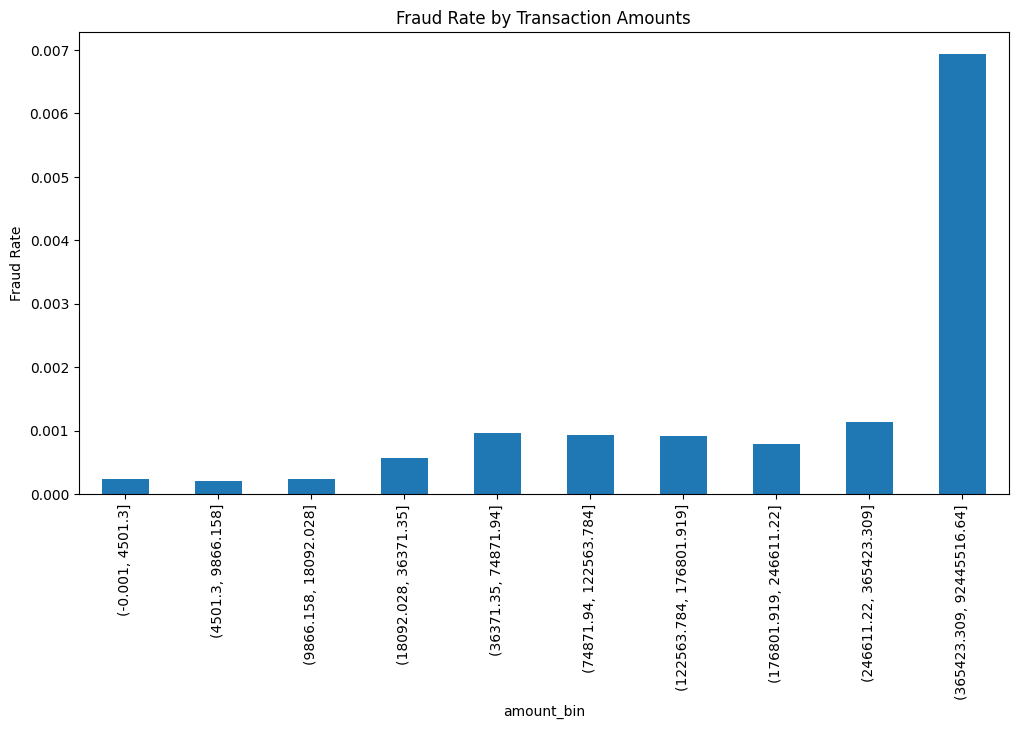

In [13]:
df['amount_bin']=pd.qcut(df['amount'],10)
fraud_rate=df.groupby('amount_bin')['isFraud'].mean()
fraud_rate.plot(kind='bar', figsize=(12,6))
plt.title('Fraud Rate by Transaction Amounts')
plt.ylabel('Fraud Rate')
plt.show()

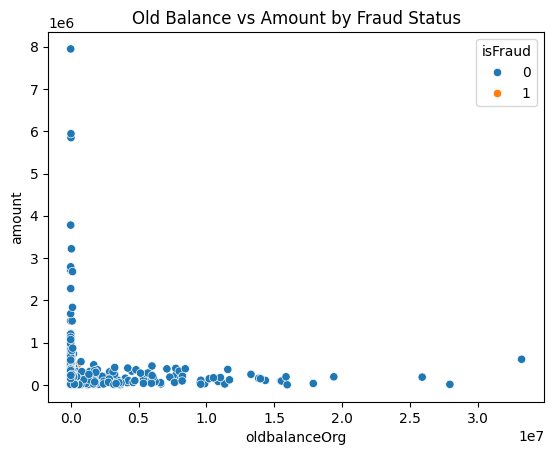

In [14]:
sns.scatterplot(x='oldbalanceOrg', y='amount', hue='isFraud', data=df.sample(1000))
plt.title('Old Balance vs Amount by Fraud Status')
plt.show()

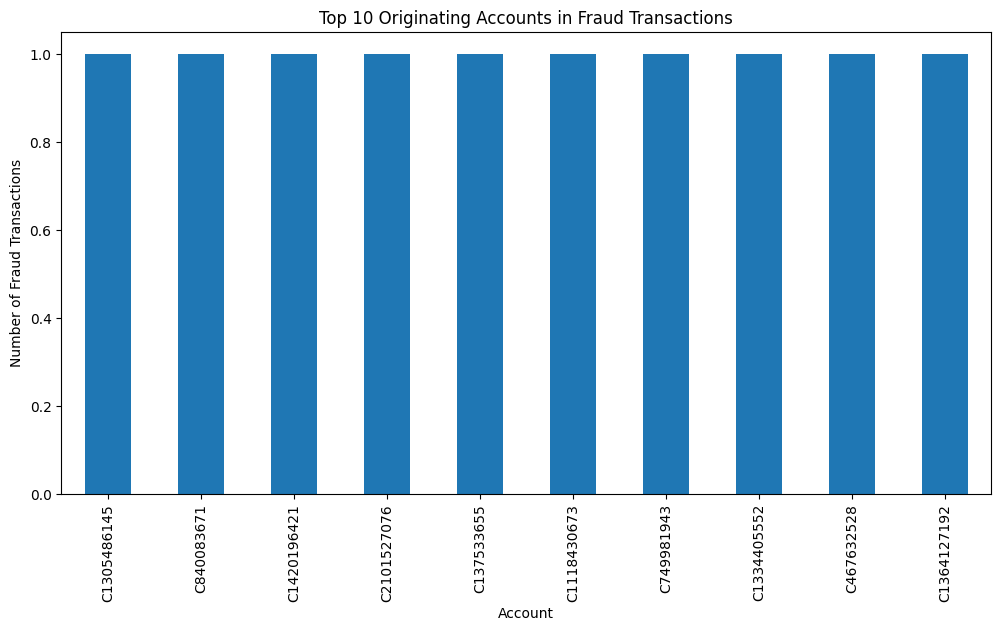

In [15]:
df_origin_in_fraud = df[df['isFraud']==1]['nameOrig'].value_counts().head(10)
df_origin_in_fraud.plot(kind='bar', figsize=(12,6))
plt.title('Top 10 Originating Accounts in Fraud Transactions')
plt.xlabel('Account')
plt.ylabel('Number of Fraud Transactions')
plt.show()

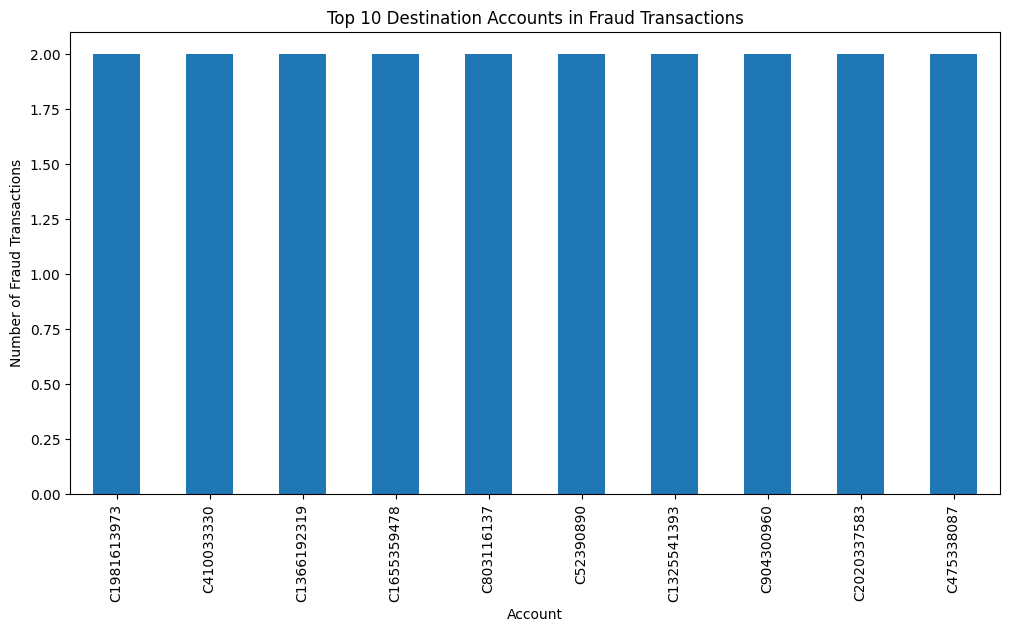

In [19]:
df_dest_in_fraud = df[df['isFraud']==1]['nameDest'].value_counts().head(10)
df_dest_in_fraud.plot(kind='bar', figsize=(12,6))
plt.title('Top 10 Destination Accounts in Fraud Transactions')
plt.xlabel('Account')
plt.ylabel('Number of Fraud Transactions')
plt.show()

In [17]:
df_origin_in_fraud

nameOrig
C1305486145    1
C840083671     1
C1420196421    1
C2101527076    1
C137533655     1
C1118430673    1
C749981943     1
C1334405552    1
C467632528     1
C1364127192    1
Name: count, dtype: int64

In [18]:
df_dest_in_fraud

nameDest
C1981613973    2
C410033330     2
C1366192319    2
C1655359478    2
C803116137     2
              ..
C2013070624    1
C1408872887    1
C1840253816    1
C659106449     1
C377165949     1
Name: count, Length: 8169, dtype: int64

In [20]:
pd.crosstab(df['isFraud'], df['isFlaggedFraud'], normalize='index')

isFlaggedFraud,0,1
isFraud,,
0,1.000000,0.000000
1,0.998052,0.001948
